In [178]:
import pandas as pd
import glove
from gensim.models import Word2Vec
import numpy as np
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from collections import Counter
from scipy.sparse import csr_matrix
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from bidi.algorithm import get_display

# Load the data

In [217]:
df=pd.read_pickle('/data/nlp_proj/all_comments_per_writer_df2.pkl')

In [3]:
print("The shape of the data is:{0}.\n{1} is the total number of comments,\nand {2} is the number of columns (features) I collected for each comment.".format(df.shape,df.shape[0],df.shape[1]))
print("\nThe columns of the data are:{}".format(list(df.columns)))
print("\nNumber of unique articles:{}".format(df.article_id.nunique()))
print("\nNumber of unique writers:{}".format(df.name.nunique()))
print('\n')
print("An example to five random rows in the data:\n")
df.sample(5)


The shape of the data is:(3439654, 15).
3439654 is the total number of comments,
and 15 is the number of columns (features) I collected for each comment.

The columns of the data are:['name', 'comment_number', 'comment_to', 'comments', 'comments_body', 'maybe_signature', 'date', 'time', 'original_comment_to', 'article_id', 'datetime', 'clean_comments', 'clean_comments_body', 'comment_to_name', 'original_comment_to_name']

Number of unique articles:113619

Number of unique writers:4439


An example to five random rows in the data:



,name,comment_number,comment_to,comments,comments_body,maybe_signature,date,time,original_comment_to,article_id,datetime,clean_comments,clean_comments_body,comment_to_name,original_comment_to_name
1,tsvika,1,0,"בלון גז, מספר פצועים",,,20.06.18,12:19,0.0,481593,2018-06-20 12:19:00,בלון גז מספר פצועים,,החדשות החמות,החדשות החמות
45,ירבה דעת,39,12,תורו ברשימה?,🇮🇱 עם ישראל חי 🇮🇱,🇮🇱 עם ישראל חי 🇮🇱,28.07.18,19:15,12.0,490605,2018-07-28 19:15:00,תורו ברשימה,עם ישראל חי,beni_israel,beni_israel
71,DOMINO D,57,54,ממש לא,השיר של אסלנד לא בולט בכלל .בלדה משמימה יש עוד...,,03.05.18,18:17,54.0,469537,2018-05-03 18:17:00,ממש לא,השיר של אסלנד לא בולט בכלל בלדה משמימה יש עוד ...,669,669
44,דני מכפר סבא,13,0,הפיתרון: להוציא מכרז לחברה מחו''ל לצורך ההקמה....,"""החלימה"" http://bloogerisrael.blogspot.com/201...","""החלימה"" http://bloogerisrael.blogspot.com/201...",23.08.18,21:23,0.0,496889,2018-08-23 21:23:00,הפיתרון להוציא מכרז לחברה מחו ל לצורך ההקמה גו...,החלימה http bloogerisrael blogspot com 2018 08...,gold1980,gold1980
81,זאביק השועל,121,19,בדיוק!,,,11.08.18,07:56,19.0,493848,2018-08-11 07:56:00,בדיוק,,דוידוב,דוידוב


The "article id" is the id of the article, and you can see the article in the link: https://rotter.net/forum/scoops1/ARTICLE_ID.shtml  where ARTICLE_ID should be replaced with the actual article_id.

# Preprocessing

### Defining Thresholds

In [214]:
TH_comments=90
TH_articles=50

### Aplying the Thresholds:
<p> Remove users with less than <b>TH_comments</b> comments in <b>TH_comments</b> unique articles, and articles with less than <b>TH_article</b> comments:<p>

In [219]:
print("number of users before applying the threshold : {}".format(df.name.nunique()))
relevant_names=df.groupby('name')['article_id'].nunique()
relevant_names.sort_values(ascending=False, inplace=True)
relevant_names=relevant_names.index[relevant_names>TH_comments]
df=df[df.name.isin(relevant_names)]
print("number of users after applying the threshold : {}".format(df.name.nunique()))

number of users before applying the threshold : 4439
number of users after applying the threshold : 2335
number of users before applying the threshold : 2335
number of users after applying the threshold : 2335


In [6]:
print("number of articles before applying the threshold : {}".format(df.article_id.nunique()))
relevant_articles=df.groupby('article_id').size()
relevant_articles=relevant_articles.index[relevant_articles>TH_articles]
df=df[df.article_id.isin(relevant_articles)]
print("number of articles after applying the threshold : {}".format(df.article_id.nunique()))

number of articles before applying the threshold : 113432
number of articles after applying the threshold : 19078


<p> So, we are left with relatively about a half of our original users, and about 1/6 of our original articles, <br> but we have to remember that we are left with the most "fruitful" users,<br> and with the most interesting (in terms of public interest) articles</p> 

# adding a unique identifier randomly to nicknames

<p> In order to be able to test the quality of my results,<br>I'm going to add a suffix to usernames in random (p=0.5).<br> The suffix would be "#" at the end of the nickname.<br> In other words, if someones username is "John", <br>in about a half of the articles his name will be "John"<br> and in about another half of the articles his name will be "John#". </p>

In [7]:
all_articles=df.article_id.unique()

In [8]:
np.random.seed(47)  #for reproducability
all_dfs=[]
for a in tqdm(all_articles):
    curr_df=df[df.article_id==a]
    curr_names=curr_df.name.unique()
    sampled_names=np.random.choice(curr_names,size=len(curr_names)//2,replace=False)
    curr_df['name']=np.where(curr_df.name.isin(sampled_names),curr_df.name.str.strip('#')+'#',curr_df.name)
    curr_df['comment_to_name']=np.where(curr_df.comment_to_name.isin(sampled_names),curr_df.comment_to_name.str.strip('#')+'#',curr_df.comment_to_name)
    curr_df['original_comment_to_name']=np.where(curr_df.original_comment_to_name.isin(sampled_names),curr_df.original_comment_to_name.str.strip('#')+'#',curr_df.original_comment_to_name)
    if not all_dfs:
        all_dfs=[curr_df]
    else:
        all_dfs.append(curr_df)
this_df=pd.concat(all_dfs)
pd.to_pickle(this_df,'/data/nlp_proj/all_comments_per_writer_df_with_hash.pkl')

  0%|          | 0/19078 [00:00<?, ?it/s]/home/binyamine/.conda/envs/standard_anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/binyamine/.conda/envs/standard_anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/binyamine/.conda/envs/standard_anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [5]:
df=pd.read_pickle('/data/nlp_proj/all_comments_per_writer_df_with_hash.pkl')

# Train Word2Vec

### creating the "sentences" - chained nicknames for each article

In [6]:
small_df=df[['name','article_id']]
article_id_u = sorted(df.article_id.unique())
sentences=[]
for a in tqdm(article_id_u):
    sentence = small_df[small_df.article_id == a]['name'].str.cat(sep=',').split(',')
    sentences.append(sentence)

100%|██████████| 19078/19078 [00:40<00:00, 468.06it/s]


### running the model itself

In [7]:
model=Word2Vec(sentences=sentences,size=30,window=400,min_count=70, workers=32)
X=model[model.wv.vocab]
names=model.wv.vocab.keys()
names_df=pd.DataFrame(X)
names_df.index=names
names_df.to_csv('/data/nlp_proj/all_names_hashed_vecs_size_30_min_count_70.csv')

/home/binyamine/.conda/envs/standard_anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


## Analyzing the results

### creating similarity matrix between the names

In [9]:
p=cosine_similarity(X)
users_df=pd.DataFrame(p,columns=names, index=names)
users_df.to_csv('word2vec_similarity_all_users_gt_70.csv')

In [2]:
users_df=pd.read_csv('word2vec_similarity_all_users_gt_70.csv') #after we already created the df we simply load it
users_df=users_df.set_index(users_df.columns[0])

In [7]:
print(users_df.shape)
users_df.head(3)

(3514, 3514)


,תכלת דומה לים#,רוסו#,CheshireCat69#,מהיהודים,Hermon#,זאביק השועל#,בראל,יריחו3,marko#,אניהיא#,...,איש-קש,בעז,Ben1#,popay#,רוכב ערבות,וו ווי#,בראל#,brosh#,דרומייי#,הדרקון#
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
תכלת דומה לים#,1.000000,-0.074395,-0.160330,-0.089181,0.316900,0.096250,0.150296,-0.025004,-0.017811,-0.111716,...,0.261849,0.359232,0.003672,0.028435,0.322437,0.025839,0.039522,-0.039706,0.240161,-0.302293
רוסו#,-0.074395,1.000000,0.006772,-0.146821,-0.260288,0.172274,0.037877,-0.068024,0.142582,0.164461,...,0.123769,0.161645,-0.096098,0.080987,-0.080909,0.014858,0.095964,-0.211689,-0.134291,-0.244979
CheshireCat69#,-0.160330,0.006772,1.000000,0.211595,0.033611,0.218270,-0.211127,-0.071285,0.288324,0.163757,...,-0.185337,0.272093,0.113910,-0.120093,-0.106033,0.168780,-0.283318,-0.168962,0.087750,0.170193


### checking the rank of each "created" nick against the original nick

<p> As explained before, I took each nick, and about half of the time I left the nick as is, and about another half of the times I appended "#" to the nick. <br>
What I am checking now is, in the similarity measure table I created (that uses cosine-similarity),<br>
what will be the average rank of each "created" nick to the original nick. <br>
For sure, the similarity of a nick to itself will be the highest, the rank will be 0,  and the similarity will always be 1. <br>
But as we know that the original nick and the created nick (the #-appended nick) are basically the same person,<br> if the method works well the average rank of the #-appended nick should be low.
As there are 3514 nicks (1757 original nicks and 1757 "fake" nicks that corresponds to the original nicks) - a totally random method will yield an average rank of about 1757 (the average case). As close as the average rank would be to 0 - as good as we will know the method is. 

In [3]:
original_columns=[c for c in users_df.columns if not c.endswith('#')]

In [4]:
all_indexes=[]
original_names=[]
for o_c in tqdm(original_columns):
    try:
        curr_series=users_df[o_c]
        curr_series=users_df[o_c].sort_values(ascending=False)
        curr_index=curr_series.index.get_loc(o_c+'#')
        all_indexes.append(curr_index)
        original_names.append(o_c)
    except:
        print(o_c)
similarity_series=pd.Series(all_indexes, index=original_names)

  8%|▊         | 144/1761 [00:00<00:02, 707.32it/s]

w00t
בית חבד
ענק השפלה
eyalsh
פיפו
Picho
egel
האיש שבקיר
daniel68
shush


 16%|█▋        | 289/1761 [00:00<00:02, 714.14it/s]

עםהנצח
פינוקיו
בנימין
The Last One
סנוב
יוסף חיים
אבי מהצפון
askobilv
Dking


 25%|██▍       | 436/1761 [00:00<00:01, 721.69it/s]

הקלריקל
טוני
שחורי
Gavrik
רוני
moshe555
יצמח פורקניה
Tachlit
חצילון
אייל_ביבי
עובדתי
אידית77


 33%|███▎      | 583/1761 [00:00<00:01, 726.26it/s]

LiavAvraham
היפוקסיה
טרנספר
Masoolin2
הדגזהב
משה צעירי
angular
אסד
איש המדבר
הלוחש לסוסים


 46%|████▌     | 803/1761 [00:01<00:01, 724.69it/s]

Max555
mwg
TecNodRom
זוז
oranus
יהודי_ישראלי
ברוש
מסי פרגוסון
jointil


 54%|█████▎    | 946/1761 [00:01<00:01, 716.00it/s]

המיוחד
חוד החנית
PaPaPanda
השומר הצעיר
החלילן
סבי


 62%|██████▏   | 1093/1761 [00:01<00:00, 723.86it/s]

Bostonterrier
Makelove
danielc
חיריק
ירושלמי02
אריאל1


 79%|███████▉  | 1390/1761 [00:01<00:00, 731.30it/s]

זונטיק
שרלוק הולמס
israel67
מגדלהשן
מוסקבה
Rubicon
פרש צפוני
eliko


 87%|████████▋ | 1537/1761 [00:02<00:00, 728.15it/s]

Idan
blue eyes
צ'ארלי דלתא
היפכא מסתברא
רגב טל
פלוני


 96%|█████████▌| 1684/1761 [00:02<00:00, 728.21it/s]

בוגו
בר-יוחאי
טוקסידו צחור
שלג לבן
yosef13
simonik
נפתלי
דבר והיפוכו


100%|██████████| 1761/1761 [00:02<00:00, 724.96it/s]

לא פה ולא פה
איש-קש
רוכב ערבות


In [14]:
print("mean rank: {}".format(similarity_series.mean()))
print("median rank: {}".format(similarity_series.median()))
print("75% quantile: {}".format(similarity_series.quantile(0.75)))
print("90% quantile: {}".format(similarity_series.quantile(0.9)))

mean rank: 188.00836320191158
median rank: 22.0
75% quantile: 129.75
90% quantile: 479.70000000000005


<p><b> We see that the results are not bad at all! out of more than 3k nicknames, 50% of the ranks are smaller than 22, 75% of the ranks are smaller than 130, and 90% are smaller than 480!</b> </p>

### histogram of the results

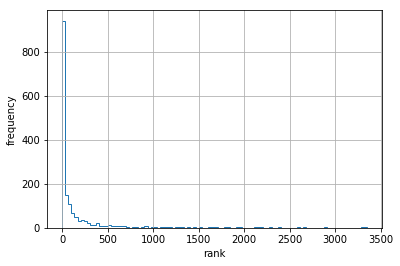

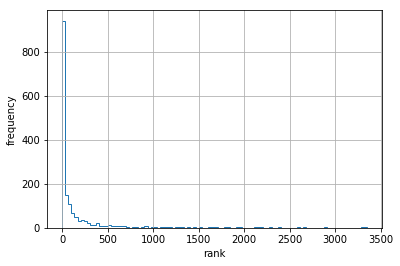

In [160]:
similarity_series.hist(bins=100,histtype='step')
#plt.title('Word2Vec ranks distribution')
plt.xlabel('rank')
_=plt.ylabel('frequency')

In [39]:
Counter(similarity_series).most_common(20)

[(1, 262),
 (2, 102),
 (3, 80),
 (6, 46),
 (4, 39),
 (8, 37),
 (5, 35),
 (7, 30),
 (12, 27),
 (9, 23),
 (11, 23),
 (10, 22),
 (13, 17),
 (29, 17),
 (17, 15),
 (15, 14),
 (16, 14),
 (14, 12),
 (18, 12),
 (23, 12)]

<b>262 of the pairs, about 1/7, were ranked first, using the word2vec method!</b>

# LDA Analysis

## loading the data

In [26]:
df2=pd.read_pickle('/data/nlp_proj/all_comments_per_writer_df_with_hash.pkl')

<p> For the LDA process, we will need to clean the text as much as we can. I already cleaned it in the scraping process, but in rotter.net there is a <b>signature</b> - a short sentence or phrase that can be added to each message. This can of course add a lot of noise - so I would like to get rid of the signatures. In the process of the scraping I already marked "candidates" for signatures, base on HTML/CSS elements etc., but here I would like to get rid of the signatures completely.</p>

In [27]:
df2

,name,comment_number,comment_to,comments,comments_body,maybe_signature,date,time,original_comment_to,article_id,datetime,clean_comments,clean_comments_body,comment_to_name,original_comment_to_name
0,Mr W,0,-1,מנהיג צפון קוריאה: כפתור גרעיני הותקן בשולחן ה...,"מנהיג צפון קוריאה, קים ג'ון און, מתפאר שבשולחן...",(adsbygoogle = window.adsbygoogle || []).push(...,01.01.18,02:59,0.0,445507,2018-01-01 02:59:00,מנהיג צפון קוריאה כפתור גרעיני הותקן בשולחן הע...,מנהיג צפון קוריאה קים ג ון און מתפאר שבשולחן ה...,nan,Mr W
1,פובליציסט,1,0,"ככה זה, קים מזמין הפצצה גרעינית, וטראמפ מזמין ...",,,01.01.18,03:02,0.0,445507,2018-01-01 03:02:00,ככה זה קים מזמין הפצצה גרעינית וטראמפ מזמין רק...,,Mr W,Mr W
2,joe,2,0,עכשיו צריך רק להפציץ את השולחן,,,01.01.18,03:18,0.0,445507,2018-01-01 03:18:00,עכשיו צריך רק להפציץ את השולחן,,Mr W,Mr W
3,חתול,4,2,גדולל,,,01.01.18,03:22,2.0,445507,2018-01-01 03:22:00,גדולל,,joe,joe
4,Starback,7,2,חחחח,,,01.01.18,03:24,2.0,445507,2018-01-01 03:24:00,חחחח,,joe,joe
5,Starback,3,0,בעבר היו מטורפים שניסו וגם הצליחו להשמיד עמים ...,אבל המטורף השמן הזה מצפון קוריאה עולה על כולם ...,,01.01.18,03:18,0.0,445507,2018-01-01 03:18:00,בעבר היו מטורפים שניסו וגם הצליחו להשמיד עמים ...,אבל המטורף השמן הזה מצפון קוריאה עולה על כולם ...,Mr W,Mr W
7,צבי_ישראל#,51,41,שכחת....צוללות,או ליתר דיוק צוללת אחת לפי הפורסם - שגם אותה ל...,"בברכה, צבי ישראל ... ארץ צבי כתיב בה (...)...",01.01.18,08:51,3.0,445507,2018-01-01 08:51:00,שכחת צוללות,או ליתר דיוק צוללת אחת לפי הפורסם שגם אותה לא ...,News just in,Starback
9,צבי_ישראל#,56,54,לא הייתי מזלזל בצוללת,בפרט אם היא בקטע של משימה ''חד פעמית''-קמיקאזה...,"בברכה, צבי ישראל ... ארץ צבי כתיב בה (...)...",01.01.18,09:00,3.0,445507,2018-01-01 09:00:00,לא הייתי מזלזל בצוללת,בפרט אם היא בקטע של משימה חד פעמית קמיקאזהלגבי...,News just in,Starback
10,SpinozaB,59,56,אתה חושב שפצצה אחת תשמיד את אמריקה... מקסימום ...,"במדבר י""ג, ל""ג: ""..ונהי בעינינו כחגבים וכן היי...","במדבר י""ג, ל""ג: ""..ונהי בעינינו כחגבים וכן היי...",01.01.18,09:09,3.0,445507,2018-01-01 09:09:00,אתה חושב שפצצה אחת תשמיד את אמריקה מקסימום ימו...,במדבר י ג ל ג ונהי בעינינו כחגבים וכן היינו בע...,צבי_ישראל#,Starback
11,צבי_ישראל#,60,59,לא להשמדה פיזית התכוונתי,יותר לעידן של פחד וחששותבדיוק כמו שאירופה עברה...,"בברכה, צבי ישראל ... ארץ צבי כתיב בה (...)...",01.01.18,09:14,3.0,445507,2018-01-01 09:14:00,לא להשמדה פיזית התכוונתי,יותר לעידן של פחד וחששותבדיוק כמו שאירופה עברה...,SpinozaB,Starback


In [60]:
df2['clean_comments_body_no_signature'] = df2.apply(lambda x: x["clean_comments_body"].replace(x["maybe_signature"], "").strip(), axis=1)

<p> Now I will concatenate the comment body and the header</p>

In [74]:
df2['all_text_clean']=df2['clean_comments']+' '+df2['clean_comments_body_no_signature']

In [75]:
pd.to_pickle(df2,'/data/nlp_proj/all_comments_per_writer_df_with_hash_with_cleaning_signature.pkl' )

<p> In order to apply the LDA, I will concatenate all the text from each user, after all the preprocessing </p>

In [105]:
grouped_by_user=df2.groupby('name')['all_text_clean'].apply(lambda x: "%s" % ' '.join(x)).reset_index()

In [108]:
grouped_by_user['all_text_clean']=grouped_by_user['all_text_clean'].str.split()

In [150]:
grouped_by_user.head(10)

,name,all_text_clean
0,-השומר-,"[מן, הסתם, זה, סקוטצ, אתמול, היה, טוב, ויהיה, ..."
1,-השומר-#,"[נשמע, היטב, אתמול, היה, טוב, ויהיה, גם, מחר, ..."
2,-ירושלמי-,"[תסבירו, לה, שכבר, בשנות, ה80, היו, עושים, את,..."
3,-ירושלמי-#,"[אכב, לא, יודע, אם, משהו, שם, לב, לאן, נעלמו, ..."
4,007,"[חכה, חצי, שעה, ערוץ, 13, גל, תקיפות, נוסף, אש..."
5,007#,"[פוש, עימותים, קשים, במקום, פוש, מצריך, פוש, ל..."
6,09meir09,"[מקווה, שהם, הסכימו, לרחוץ, רגליים, לפני, מה, ..."
7,09meir09#,"[טעות, לעזוב, את, רוסיה, גם, יש, לו, בשר, תותח..."
8,1984,"[חירטוטים, החוק, הבין, לאומי, קובע, שפליט, הוא..."
9,1984#,"[עונש, מוות, הוא, הדבר, הנכון, מוסרית, עונש, מ..."


In [110]:
users=grouped_by_user['name']
texts=grouped_by_user['all_text_clean'].values

In [111]:
dictionary = Dictionary(texts)

In [112]:
corpus = [dictionary.doc2bow(text) for text in texts]

In [163]:
for n_topics in [10,15,20]:
    for decay in [0.5, 0.7, 0.9]:
        lda = LdaModel(corpus, num_topics=n_topics, decay=decay)
        lda_matrix=[lda[c] for c in corpus]
        i, j, data = zip(*((i, t[0], t[1]) for i, row in enumerate(lda_matrix) for t in row))
        dense_lda=csr_matrix((data, (i, j)), shape=(len(corpus), n_topics)).todense()
        df_lda=pd.DataFrame(dense_lda, index=users)
        sim=cosine_similarity(dense_lda)
        similarity_df=pd.DataFrame(sim, index=users, columns=users)
        original_columns=[c for c in similarity_df.columns if not c.endswith('#')]
        all_indexes2=[]
        original_names2=[]
        for o_c in tqdm(original_columns):
            try:
                curr_series=similarity_df[o_c]
                curr_series=similarity_df[o_c].sort_values(ascending=False)
                curr_index=curr_series.index.get_loc(o_c+'#')
                all_indexes2.append(curr_index)
                original_names2.append(o_c)
            except:
                continue
        similarity_series2=pd.Series(all_indexes2, index=original_names2)
        print("n topics:{0}\n decay:{1}\n mean rank:{2}".format(n_topics,decay,similarity_series2.mean()))


100%|██████████| 2334/2334 [00:03<00:00, 651.47it/s]


n topics:10
 decay:0.5
 mean rank:411.2918988426918


100%|██████████| 2334/2334 [00:03<00:00, 659.65it/s]


n topics:10
 decay:0.7
 mean rank:545.0240034290613


100%|██████████| 2334/2334 [00:03<00:00, 655.70it/s]


n topics:10
 decay:0.9
 mean rank:512.3124732104586


100%|██████████| 2334/2334 [00:03<00:00, 680.80it/s]


n topics:15
 decay:0.5
 mean rank:494.058294042006


100%|██████████| 2334/2334 [00:03<00:00, 643.27it/s]


n topics:15
 decay:0.7
 mean rank:583.1663094727818


100%|██████████| 2334/2334 [00:03<00:00, 647.52it/s]


n topics:15
 decay:0.9
 mean rank:524.912558936991


100%|██████████| 2334/2334 [00:05<00:00, 466.15it/s]


n topics:20
 decay:0.5
 mean rank:447.4603514787827


100%|██████████| 2334/2334 [00:05<00:00, 462.41it/s]


n topics:20
 decay:0.7
 mean rank:492.8975567938277


100%|██████████| 2334/2334 [00:04<00:00, 474.63it/s]

n topics:20
 decay:0.9
 mean rank:426.46335190741536


Running again with the best parameters:

In [165]:
for n_topics in [10]:
    for decay in [0.5]:
        lda = LdaModel(corpus, num_topics=n_topics, decay=decay)
        lda_matrix=[lda[c] for c in corpus]
        i, j, data = zip(*((i, t[0], t[1]) for i, row in enumerate(lda_matrix) for t in row))
        dense_lda=csr_matrix((data, (i, j)), shape=(len(corpus), n_topics)).todense()
        df_lda=pd.DataFrame(dense_lda, index=users)
        sim=cosine_similarity(dense_lda)
        similarity_df=pd.DataFrame(sim, index=users, columns=users)
        original_columns=[c for c in similarity_df.columns if not c.endswith('#')]
        all_indexes2=[]
        original_names2=[]
        for o_c in tqdm(original_columns):
            try:
                curr_series=similarity_df[o_c]
                curr_series=similarity_df[o_c].sort_values(ascending=False)
                curr_index=curr_series.index.get_loc(o_c+'#')
                all_indexes2.append(curr_index)
                original_names2.append(o_c)
            except:
                continue
        similarity_series2=pd.Series(all_indexes2, index=original_names2)
        print("n topics:{0}\n decay:{1}\n mean rank:{2}".format(n_topics,decay,similarity_series2.mean()))


100%|██████████| 2334/2334 [00:03<00:00, 617.17it/s]

n topics:10
 decay:0.5
 mean rank:467.5113587655379



100%|██████████| 2334/2334 [00:03<00:00, 650.44it/s]

n topics:10
 decay:0.5
 mean rank:531.757822546078


In [167]:
print("mean rank: {}".format(similarity_series2.mean()))
print("median rank: {}".format(similarity_series2.median()))
print("75% quantile: {}".format(similarity_series2.quantile(0.75)))
print("90% quantile: {}".format(similarity_series2.quantile(0.9)))

mean rank: 531.757822546078
median rank: 155.0
75% quantile: 640.0
90% quantile: 1689.6000000000004
mean rank: 531.757822546078
median rank: 155.0
75% quantile: 640.0
90% quantile: 1689.6000000000004


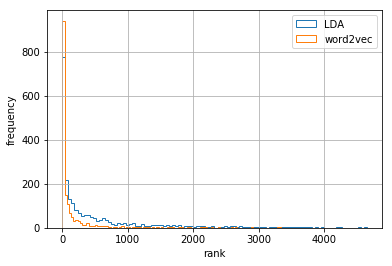

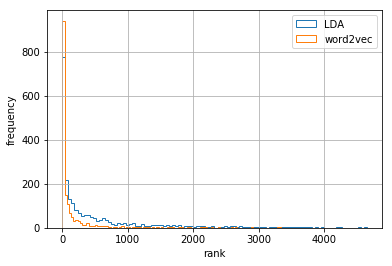

In [173]:
similarity_series2.hist(bins=100,histtype='step',label='LDA')
similarity_series.hist(bins=100,histtype='step',label='word2vec')
#plt.title('ranks distribution')
plt.xlabel('rank')
plt.legend()
_=plt.ylabel('frequency')

<p> We see here that the results are far less good than in the word2vec model. It is still far better than the baseline, but the median jumped from 22 to 129.</p>

Lets look if we can detect some topics. 
As a showcase, let's take (arbitraraly) topic 2, and see what users scored the highest scored on this topic: 

In [236]:
df_lda.sort_values(by=2, ascending=False).head(10)

,0,1,2,3,4,5,6,7,8,9
name,,,,,,,,,,
Liron,0.0,0.0,0.999983,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Liron#,0.0,0.0,0.999981,0.0,0.0,0.0,0.0,0.0,0.0,0.0
צפוני_לעד,0.0,0.0,0.999964,0.0,0.0,0.0,0.0,0.0,0.0,0.0
צפוני_לעד#,0.0,0.0,0.999960,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Rocky,0.0,0.0,0.999956,0.0,0.0,0.0,0.0,0.0,0.0,0.0
מרכזי,0.0,0.0,0.999950,0.0,0.0,0.0,0.0,0.0,0.0,0.0
מרכזי#,0.0,0.0,0.999947,0.0,0.0,0.0,0.0,0.0,0.0,0.0
דניניו#,0.0,0.0,0.999931,0.0,0.0,0.0,0.0,0.0,0.0,0.0
שועל זהב#,0.0,0.0,0.999929,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's take the top 3 users: Liron, Rocky  and צפוני_לעד and see how the wordcloud made from their comments looks like:

In [231]:
df2['all_text_clean']=df2['clean_comments_body_no_signature']+' '+ df2['clean_comments']

In [232]:
v = TfidfVectorizer(max_df=0.3)
v.fit(df2.groupby('name')['all_text_clean'].apply(lambda x: x.str.cat(sep=' ')))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.3, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [233]:
word2idf=dict(zip(v.vocabulary_,v.idf_))

def tfidf_from_text(text):
    tf=Counter(text.split(' ')).most_common()
    tfidf={get_display(x[0]):x[1]*word2idf.get(x[0],0) for x in tf if word2idf.get(x[0],0)>0}
    return tfidf

Liron


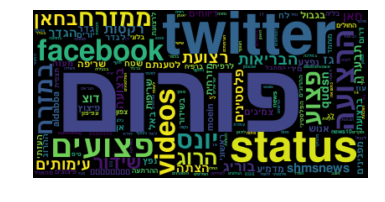

Rocky


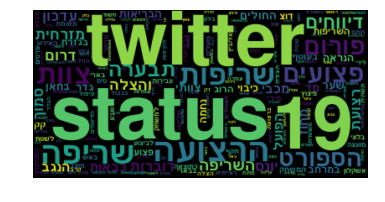

מרכזי


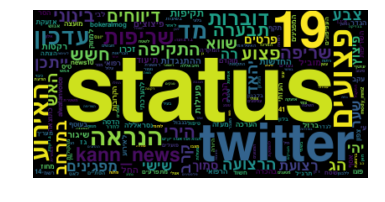

In [238]:
for writer_name in ['Liron', "Rocky", "מרכזי"]:
    plt.clf()
    print(writer_name)
    text=df2[df2.name==writer_name]['all_text_clean'].str.cat(sep=' ')
    d=tfidf_from_text(text)
    bidi_text = get_display(text)
    font_path='/home/binyamine/fonts/FreeSans/FreeSansBold.ttf'
    wordcloud = WordCloud(font_path=font_path).generate_from_frequencies(d)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    plt.title=writer_name
    plt.show()

We see that they all talking about Twitter, burnings, and the Gaza strip. 